# Challenge task: Crime data analysis using MongoDB, PySpark and Jupyter

**Author:** Alonso Andrade Blázquez

### Task statement

This excercise proposes to combine three of the tools that have been using during the master: MongoDB, Spark (PySpark) and Jupyter. The data source to be analyzed are the incidents of crime of the city of Chicago (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2), which has 6.55 million of rows. The data file has to be previosly loaded into a MongoDB database.

The tasks consistst on developing a Juypter notebook including the following steps:

1. Link the MongoDB database and infer its scheme.

2. Store in a .csv file all the records but only including the ID field plus all the fields related to the location of the incidents (x and coordinates, latitude, longitude, location).

3. Ask the user for a range of dates (begin, end).

4. Find the number of records per "Primary Type" and display a bar graph with the higuest 10 types having more frequency during the range of dates.

5. Display a line graph with the number of incidents per year during the range indicated of dates.

Only the Spark dataframe API should be used.

The deliverable with be a Jupiter notebook and one (or several) screen captures show how it works.

**Importing required packages**

In [2]:
import pymongo
from pymongo import MongoClient, GEO2D

import os
import pandas as pd

from pyspark.sql import SparkSession
from pyspark.sql.functions import unix_timestamp

### 0. Importing file to MongoDB

In [5]:
# Check MongoDB version installed in the OS
print('Mongo version', pymongo.__version__)

# Set MongoDB client
client = MongoClient('localhost', 27017)

# Set MongoDB database
database_name = 'SparkMongoChallenge'
db = client[database_name]

# Create a new collection to store Chicago crimes
collection_chicago_crimes = db.ChicagoCrimes
collection_chicago_crimes.drop()

Mongo version 3.6.1


In [10]:
# MongoBD import from tsv file
os.system('"C:\\Program Files\\MongoDB\\Server\\3.4\\bin\\mongoimport" \
            -d SparkMongoChallenge -c ChicagoCrimes \
            --type tsv \
            --file C:\\Users\\Alonso\\Desktop\\spark\\Challenge_tasks\\Crimes_-_2001_to_present.tsv \
            --headerline')

0

In [14]:
# Check if mongoimport was correctly performed
cursor = collection_chicago_crimes.find().limit(1)
for document in cursor:
    print(document)

{'_id': ObjectId('5ad0e90240bf54f4f22e735a'), '': 0, 'ID': 10000092, 'Case Number': 'HY189866', 'Date': '03/18/2015 07:44:00 PM', 'Block': '047XX W OHIO ST', 'IUCR': '041A', 'Primary Type': 'BATTERY', 'Description': 'AGGRAVATED: HANDGUN', 'Location Description': 'STREET', 'Arrest': 'False', 'Domestic': 'False', 'Beat': 1111, 'District': 11.0, 'Ward': 28.0, 'Community Area': 25.0, 'FBI Code': '04B', 'X Coordinate': 1144606.0, 'Y Coordinate': 1903566.0, 'Year': 2015, 'Updated On': '02/10/2018 03:50:01 PM', 'Latitude': 41.891398861, 'Longitude': -87.74438456700001, 'Location': '(41.891398861, -87.744384567)'}


### 1. Connect Spark with MongoDB and infer its schema

In [3]:
# Set spark session linked with MongoDB
spark_session = SparkSession \
    .builder \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.2.0') \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/SparkMongoChallenge.ChicagoCrimes") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/SparkMongoChallenge.ChicagoCrimes") \
    .master('local[4]') \
    .getOrCreate()

In [4]:
# Load collection to spark dataframe
chicago_crimes = spark_session \
                    .read \
                    .format("com.mongodb.spark.sql.DefaultSource") \
                    .load()
            
chicago_crimes.printSchema()

root
 |-- Arrest: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- Block: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- District: double (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [5]:
# Check if data was correctly loaded to spark
chicago_crimes.show(1)

+------+----+---------------+-----------+--------------+--------------------+-------------------+--------+--------+--------+--------+----+------------+--------------------+--------------------+------------------+------------+--------------------+----+------------+------------+----+--------------------+
|Arrest|Beat|          Block|Case Number|Community Area|                Date|        Description|District|Domestic|FBI Code|      ID|IUCR|    Latitude|            Location|Location Description|         Longitude|Primary Type|          Updated On|Ward|X Coordinate|Y Coordinate|Year|                 _id|
+------+----+---------------+-----------+--------------+--------------------+-------------------+--------+--------+--------+--------+----+------------+--------------------+--------------------+------------------+------------+--------------------+----+------------+------------+----+--------------------+
| False|1111|047XX W OHIO ST|   HY189866|          25.0|03/18/2015 07:44:...|AGGRAVATED:

### 2. Store in a .csv file all the records but only including the ID field plus all the fields related to the location of the incidents (x and coordinates, latitude, longitude, location).

In [6]:
# Create temporary table to perform SQL queries with the dataframe
chicago_crimes.createOrReplaceTempView("chicago_crimes")

In [7]:
# Perform requested query
sql_id_location_fields = spark_session.sql("SELECT `ID`, `X Coordinate`, `Y Coordinate`, `Latitude`, `Longitude`, `Location` \
                                            FROM chicago_crimes")

sql_id_location_fields.show(1, truncate = False)

+--------+------------+------------+------------+------------------+-----------------------------+
|ID      |X Coordinate|Y Coordinate|Latitude    |Longitude         |Location                     |
+--------+------------+------------+------------+------------------+-----------------------------+
|10000092|1144606.0   |1903566.0   |41.891398861|-87.74438456700001|(41.891398861, -87.744384567)|
+--------+------------+------------+------------+------------------+-----------------------------+
only showing top 1 row



In [8]:
sql_id_location_fields.coalesce(1) \
                      .write \
                      .option("header", "true") \
                      .mode("overwrite") \
                      .csv("file:///C:\\Users\\Alonso\\Desktop\\spark\\Challenge_tasks\\chicago_crimes_id_location.csv")

With above code, a folder with a unique file was created. Preview of the output file and folder:

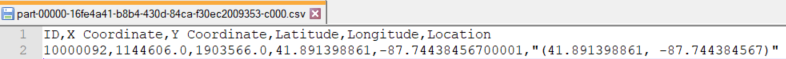

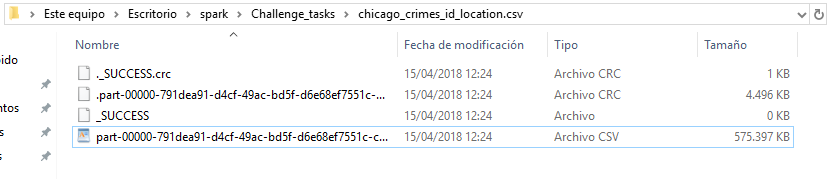

### 3.- Ask the user for a range of dates (begin, end).

It is necessary to convert ``Date`` column in a proper format in order to operate with dates. For that purpose, a casting will be performed from ``string`` (indicating the pattern that follows the date in string in the current dataset) to ``timestamp``, using ``unix_timestamp`` function and a casting.

In [12]:
from_pattern = "MM/dd/yyyy hh:mm:ss aa"

chicago_crimes_timestamp_format = chicago_crimes \
                                .withColumn("Date", unix_timestamp(chicago_crimes["Date"], from_pattern) \
                                .cast("timestamp"))
    
chicago_crimes_timestamp_format.printSchema()

root
 |-- Arrest: string (nullable = true)
 |-- Beat: integer (nullable = true)
 |-- Block: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- District: double (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- ID: integer (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [13]:
chicago_crimes_timestamp_format.show(1, truncate = False)

+------+----+---------------+-----------+--------------+-------------------+-------------------+--------+--------+--------+--------+----+------------+-----------------------------+--------------------+------------------+------------+----------------------+----+------------+------------+----+--------------------------+
|Arrest|Beat|Block          |Case Number|Community Area|Date               |Description        |District|Domestic|FBI Code|ID      |IUCR|Latitude    |Location                     |Location Description|Longitude         |Primary Type|Updated On            |Ward|X Coordinate|Y Coordinate|Year|_id                       |
+------+----+---------------+-----------+--------------+-------------------+-------------------+--------+--------+--------+--------+----+------------+-----------------------------+--------------------+------------------+------------+----------------------+----+------------+------------+----+--------------------------+
|False |1111|047XX W OHIO ST|HY189866   

We can see above that timestamp format per default is "yyyy-MM-dd hh:mm:ss". If we would prefer to display it in a different format, ``to_pattern`` could have been also indicated in the conversion.

Now we can ask the user for a range of dates:

In [14]:
START_DATE = "2010-01-01"
END_DATE = "2015-12-31"

### 4. Find the number of records per "Primary Type" and display a bar graph with the higuest 10 types having more frequency during the range of dates.

In [15]:
chicago_crimes_timestamp_format.createOrReplaceTempView("chicago_crimes_timestamp")

Let's check if the conversion to ``timestamp`` was correctly displayed by retrieving the types / dates fulfilling the given start and end date:

In [16]:
sql_crime_type_date = spark_session.sql("SELECT `Primary Type`, `Date` \
                                    FROM chicago_crimes_timestamp \
                                    WHERE `Date` >= \'" + START_DATE + "\' \
                                    AND `Date` <= \'" + END_DATE + "\' \
                                    ORDER BY `Date` DESC")

sql_crime_type_date.show(1000,truncate=False)

+--------------------------------+-------------------+
|Primary Type                    |Date               |
+--------------------------------+-------------------+
|OFFENSE INVOLVING CHILDREN      |2010-01-01 00:00:00|
|THEFT                           |2010-01-01 00:00:00|
|DECEPTIVE PRACTICE              |2010-01-01 00:00:00|
|THEFT                           |2010-01-01 00:00:00|
|CRIM SEXUAL ASSAULT             |2010-01-01 00:00:00|
|DECEPTIVE PRACTICE              |2010-01-01 00:00:00|
|OFFENSE INVOLVING CHILDREN      |2010-01-01 00:00:00|
|CRIM SEXUAL ASSAULT             |2010-01-01 00:00:00|
|BURGLARY                        |2010-01-01 00:00:00|
|OTHER OFFENSE                   |2010-01-01 00:00:00|
|CRIMINAL DAMAGE                 |2010-01-01 00:00:00|
|BURGLARY                        |2010-01-01 00:00:00|
|DECEPTIVE PRACTICE              |2010-01-01 00:00:00|
|SEX OFFENSE                     |2010-01-01 00:00:00|
|THEFT                           |2010-01-01 00:00:00|
|THEFT    

As we can see above, dates are within the requested time range.

Now let's perform the requested query:

In [17]:
sql_crimes_per_type_time = spark_session.sql("SELECT `Primary Type`, COUNT (`Primary Type`) AS `Number of crimes` \
                                            FROM chicago_crimes_timestamp \
                                            WHERE `Date` >= \'" + START_DATE + "\' \
                                            AND `Date` <= \'" + END_DATE + "\' \
                                            GROUP BY `Primary Type` \
                                            ORDER BY `Number of crimes` DESC \
                                            LIMIT(10)")

sql_crimes_per_type_time.show(truncate=False)

+-------------------+----------------+
|Primary Type       |Number of crimes|
+-------------------+----------------+
|THEFT              |417598          |
|BATTERY            |337187          |
|NARCOTICS          |204460          |
|CRIMINAL DAMAGE    |201067          |
|BURGLARY           |121480          |
|ASSAULT            |113707          |
|OTHER OFFENSE      |112150          |
|MOTOR VEHICLE THEFT|87446           |
|DECEPTIVE PRACTICE |83534           |
|ROBBERY            |72944           |
+-------------------+----------------+



**Bar chart display**

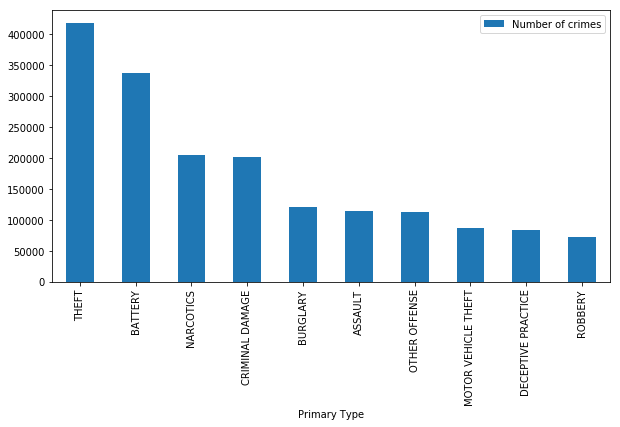

In [20]:
#Convert spark dataframe to pandas dataframe
sql_crimes_per_type_time_pandas_df = sql_crimes_per_type_time.toPandas()

#Display bar chart
sql_crimes_per_type_time_pandas_df.plot(kind ='bar', 
                                        figsize=(10,5), 
                                        x = sql_crimes_per_type_time_pandas_df['Primary Type'])

We can see above that theft and battery are the most common crimes in the selected date range.

### 5. Display a line graph with the number of incidents per year during the indicated range of dates.

In [21]:
sql_crimes_per_type_year = spark_session.sql("SELECT `Year`, COUNT (`Primary Type`) AS `Incidents per year` \
                                    FROM chicago_crimes_timestamp \
                                    WHERE `Date` >= \'" + START_DATE + "\' \
                                    AND `Date` <= \'" + END_DATE + "\' \
                                    GROUP BY `Year` \
                                    ORDER BY `Incidents per year` DESC \
                                    LIMIT(10)")

sql_crimes_per_type_year.show()

+----+------------------+
|Year|Incidents per year|
+----+------------------+
|2010|            370200|
|2011|            351673|
|2012|            335814|
|2013|            306865|
|2014|            274950|
|2015|            263027|
+----+------------------+



**Line chart display**

In [36]:
# Convert spark dataframe to pandas
sql_crimes_per_type_year_s = sql_crimes_per_type_year.withColumn("Year", sql_crimes_per_type_year["Year"].cast("string"))
sql_crimes_per_type_year_pandas_df = sql_crimes_per_type_year_s.toPandas()

In [52]:
display(sql_crimes_per_type_year_pandas_df)

,Year,Incidents per year
0,2010,370200
1,2011,351673
2,2012,335814
3,2013,306865
4,2014,274950
5,2015,263027


[Text(0,0,'2010'),
 Text(0,0,'2011'),
 Text(0,0,'2012'),
 Text(0,0,'2013'),
 Text(0,0,'2014'),
 Text(0,0,'2015')]

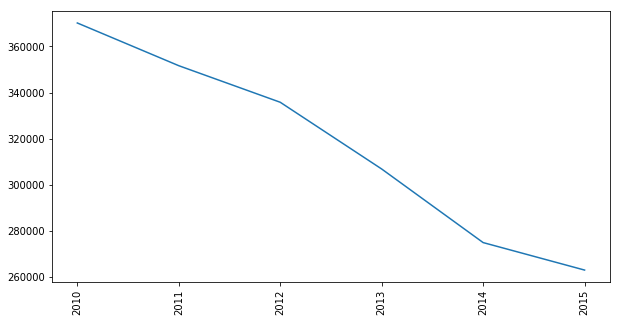

In [55]:
ax = sql_crimes_per_type_year_pandas_df["Incidents per year"].plot(figsize=(10,5))
ax.set_xticks(sql_crimes_per_type_year_pandas_df.index)
ax.set_xticklabels(sql_crimes_per_type_year_pandas_df.Year, rotation=90)

We can see above a decreasing tendency in the number of crimes in the requested date range.